In [427]:
import numpy as np
from sklearn.linear_model import Lasso
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os 
%matplotlib inline


def connect_line(arr, span_tuple):
    '''
    Return function for a line that connects two values from arr.
    Inputs:
    - arr: numpy 1d-array of time-series values
    - span_tuple: start and enpdpoints for line
    '''
    first, last = span_tuple
    run = last - first
    rise = arr[last] - arr[first]
    slope = rise / run
    intercept = arr[first] - first * slope

    return lambda x: intercept + slope * x


def line_point_distance(arr, x1, x2, x0):
    '''
    Calculate the minimal orthogonal distance from a line connecting
    (x1, arr[x1]) and (x2, arr[x2]) to a third point (x0, arr[x0])
    Distance formula from https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line.
    
    Inputs:
    - arr: numpy 1d-array of time-series values
    - x1: int, start x-value of line
    - x2: int, end x-value of line
    - x3: int, third point for distance to be calculated
    '''
    y1 = arr[x1]
    y2 = arr[x2]
    y0 = arr[x0]

    numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)

    return numerator / denominator


def farthest_point(arr, x1, x2):
    '''
    Find the farthest point between two points that define a line on a time-series.
    '''
    xx = np.arange(len(arr))

    distances_partial = partial(line_point_distance, arr, x1, x2)
    distances = distances_partial(xx)
    mask = (xx > x1) & (xx < x2)
    farthest_point_indx = np.argmax(distances[mask]) + x1
    max_distance = distances[farthest_point_indx]

    return farthest_point_indx, max_distance


def flatten(nested):
    '''
    Utility to flatten nested lists.
    '''
    flattened = []
    for item in nested:
        if type(item) != list:
            flattened.append(item)
        else:
            flattened += flatten(item)
    return flattened


def plr_recursive(arr, span_tuple, epsilon):
    '''
    Compute piece-wise linear regression on a time series.
    Inputs:
    - arr: numpy 1d-array of time-series values
    - span_tuple: start and endpoints
    - epsilon: threshold for line-breaking
    Outputs:
    - lines: list of lambda functions
    - points: list of points that dicate when lambdas should be used
    '''
    first, last = span_tuple
    farthest_indx, distance = farthest_point(arr, first, last)

    lines = []
    points = []

    if distance < epsilon: #base case
        line = connect_line(arr, span_tuple)
        point = first

        return line, point

    else: #recursive case

        line_1, point_1 = plr_recursive(arr, (first, farthest_indx), epsilon)
        line_2, point_2 = plr_recursive(arr, (farthest_indx, last), epsilon)

        lines.extend([line_1, line_2])
        points.extend([point_1, point_2])

        #flatten out recursive nests
        return flatten(lines), flatten(points)


def PLR(arr, epsilon):
    '''
    Compute full PLR for a time series
    '''
    xx = np.arange(len(arr))
    lines, points = plr_recursive(arr, (0, len(arr) -1), epsilon)

    if type(lines) != list:
        plr_values = lines(xx)
        
    else:
        plr_values = np.piecewise(xx, [xx >= point for point in points], lines)

    return plr_values, lines, points

In [428]:
def up_down_trend(arr, epsilon):
    '''
    Classify point in a time series as either in an up trend or a down trend
    as determined by a PLR.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - list of list of bools, where True indicates membership of an up trend
    '''
    pieces, lines, points = PLR(arr, epsilon)
    points.append(len(arr) - 1)
    diffs = np.diff(points)
    
    #I think this compensates for undercounting the first trend by one
    diffs[0] += 1 
    
    trend_labels = []
    
    for point, diff in zip(points[1:], diffs):
        up = [arr[point] - arr[point - 5] > 0]
        #print(up)
        #print(diff)
        #print(up * diff)
        trend_labels.append(up * diff)
    
    return trend_labels


def trading_signal(arr, epsilon):
    '''
    Convert a time-series into a trading signal ranging from 0 to 1.
    For more information refer to "A dynamic threshold decision system ..."
    by Chang et al.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - numpy 1d-array with the same length as arr
    '''
    labels = up_down_trend(arr, epsilon)
    
    
    final_signal_list = []
    for trend_list in labels:
        up = any(trend_list)
        length = len(trend_list)
        half_length, remainder = divmod(length, 2)
        

        if remainder:
            half_length += 1
            
        if up:
            first_half = 0.5 - np.arange(half_length) / length
        else:
            first_half = 0.5 + np.arange(half_length) / length
        
        if remainder:
            trend_signal = np.concatenate((first_half, first_half[-2::-1]))
        else:
            trend_signal = np.concatenate((first_half, first_half[::-1]))
        
        final_signal_list.append(trend_signal)
       
    return np.concatenate(final_signal_list)

In [429]:
from pandas_datareader import data
import talib

#apple = pd.read_csv('C:/Users/jangkoon.park/test.csv')
samsung = data.DataReader('005930.KS','yahoo', '1999-01-01') #Import historical stock data for training
#apple["Date"] = pd.to_datetime(apple["Date"])
#apple = apple.set_index("Date")
close = samsung["Close"].values


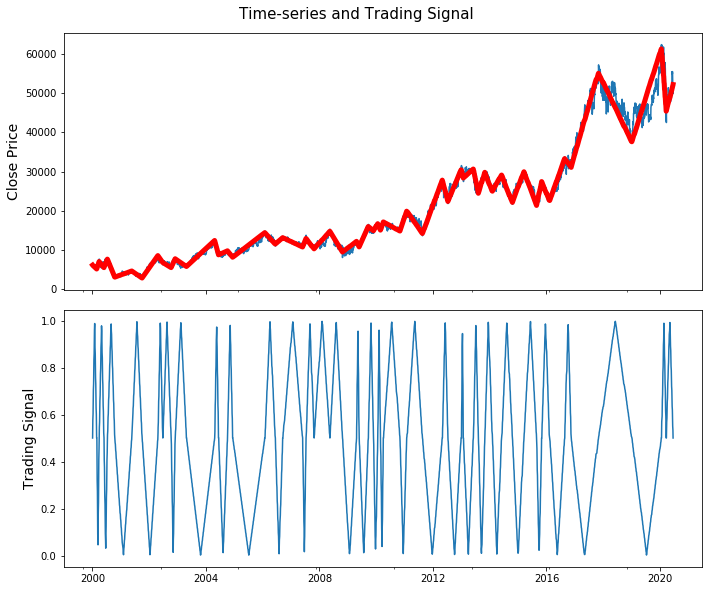

In [430]:


fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex= True, figsize = (10, 8))
fig.suptitle("Time-series and Trading Signal", y = 1.02, size = 15)
xx = np.arange(len(close))
#ax1.plot(piece, c = "red")
samsung["Close"].plot(ax = ax1 )
ax1.set_ylabel("Close Price", size = 14)

thresHold = 100
piece, lines, points = PLR(close, thresHold)

ax1.plot(samsung.index, piece, c = "red", linewidth = 5, label = "PLR (threshold 20)")

ts= trading_signal(close, thresHold)


ax2.plot(samsung.index, ts)
ax2.set_ylabel("Trading Signal", size = 14)

plt.tight_layout()

In [431]:
samsung['MA10'] = talib.MA(samsung['Close'].values, timeperiod=10, matype=0)
macd, signal, hist  = talib.MACD(samsung['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
samsung['MACD'] = macd
samsung['Target'] = ts
print(type(samsung))
samsung.dropna(inplace=True)

#samsung.to_csv('C:/Users/jangkoon.park/samsung_data.csv')

<class 'pandas.core.frame.DataFrame'>


In [432]:

samsung.head(80)

,High,Low,Open,Close,Volume,Adj Close,MA10,MACD,Target
Date,,,,,,,,,
2000-02-18,5630.0,5160.0,5370.0,5300.0,108750000.0,0.078588,5381.0,-170.945790,0.628205
2000-02-21,5260.0,5030.0,5200.0,5070.0,26485000.0,0.075178,5364.0,-179.787477,0.602564
2000-02-22,5240.0,5000.0,5000.0,5120.0,24180000.0,0.075919,5333.0,-180.677261,0.576923
2000-02-23,5260.0,5100.0,5220.0,5140.0,27720000.0,0.076216,5275.0,-177.719943,0.551282
2000-02-24,5240.0,5060.0,5120.0,5070.0,26075000.0,0.075178,5206.0,-178.961703,0.525641
...,...,...,...,...,...,...,...,...,...
2000-06-02,6900.0,6510.0,6690.0,6620.0,84385000.0,0.098161,6085.0,-44.260744,0.406250
2000-06-05,6980.0,6680.0,6920.0,6740.0,48010000.0,0.099941,6092.0,3.273335,0.375000
2000-06-06,6740.0,6740.0,6740.0,6740.0,0.0,0.099941,6128.0,40.477831,0.343750


In [416]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
train_cols = ["Open","High","Low","Close","Volume","Adj Close","MA10","MACD","Target"]
df_train, df_test = train_test_split(samsung, train_size=0.6, test_size=0.4, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
df_train.to_csv('C:/Users/jangkoon.park/samsung_data_train.csv')
df_test.to_csv('C:/Users/jangkoon.park/samsung_data_test.csv')
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values

min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

print(df_train)
print(x)
print(x_train)



Train and Test size 3061 2041
               High      Low     Open    Close       Volume  Adj Close  \
Date                                                                     
2000-02-18   5630.0   5160.0   5370.0   5300.0  108750000.0   0.078588   
2000-02-21   5260.0   5030.0   5200.0   5070.0   26485000.0   0.075178   
2000-02-22   5240.0   5000.0   5000.0   5120.0   24180000.0   0.075919   
2000-02-23   5260.0   5100.0   5220.0   5140.0   27720000.0   0.076216   
2000-02-24   5240.0   5060.0   5120.0   5070.0   26075000.0   0.075178   
...             ...      ...      ...      ...          ...        ...   
2012-02-14  21780.0  21480.0  21680.0  21600.0   12317400.0  20.880024   
2012-02-15  22760.0  21840.0  21960.0  22700.0   28522350.0  21.943356   
2012-02-16  22800.0  22420.0  22600.0  22700.0   15411800.0  21.943356   
2012-02-17  23600.0  23120.0  23180.0  23520.0   17308450.0  22.736023   
2012-02-20  23880.0  23320.0  23560.0  23500.0   14814150.0  22.716690   

       

In [452]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS

    dim_0 = mat.shape[0] - TIME_STEPS
   
    #mat.shape[0]  열수 mat.shape[1] 행수
    
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
  
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    
    
   
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [454]:
from tqdm import tqdm_notebook
BATCH_SIZE = 10
TIME_STEPS = 60

x_train_sep , y_train_sep = build_timeseries(x_train, 8)

print(x_train_sep)
print(y_train_sep)


x_train_sep = trim_dataset(x_train_sep, BATCH_SIZE)
y_train_sep = trim_dataset(y_train_sep, BATCH_SIZE)


x_test_sep, y_test_sep = build_timeseries(x_test, 8)

x_valid_sep, x_test_sep = np.split(trim_dataset(x_test_sep, BATCH_SIZE),2)
y_valid_sep, y_test_sep = np.split(trim_dataset(y_test_sep, BATCH_SIZE),2)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



length of time-series i/o (3001, 60, 9) (3001,)
[[[0.13463368 0.13589015 0.13110048 ... 0.13127095 0.38186882 0.62987232]
  [0.12654615 0.11837121 0.12488038 ... 0.13039443 0.37635885 0.60409321]
  [0.1170314  0.11742424 0.12344498 ... 0.12879608 0.37580436 0.57831411]
  ...
  [0.19124643 0.17992424 0.19808612 ... 0.168033   0.49767408 0.82087202]
  [0.17982873 0.171875   0.18421053 ... 0.17189997 0.50353309 0.79802236]
  [0.18125595 0.16998106 0.18803828 ... 0.17679814 0.50795102 0.77517271]]

 [[0.12654615 0.11837121 0.12488038 ... 0.13039443 0.37635885 0.60409321]
  [0.1170314  0.11742424 0.12344498 ... 0.12879608 0.37580436 0.57831411]
  [0.12749762 0.11837121 0.12822967 ... 0.12580562 0.3776473  0.55253501]
  ...
  [0.17982873 0.171875   0.18421053 ... 0.17189997 0.50353309 0.79802236]
  [0.18125595 0.16998106 0.18803828 ... 0.17679814 0.50795102 0.77517271]
  [0.18458611 0.17424242 0.17894737 ... 0.1776231  0.50174418 0.75232305]]

 [[0.1170314  0.11742424 0.12344498 ... 0.12879


length of time-series i/o (1981, 60, 9) (1981,)


In [445]:
import keras.models
from keras import optimizers
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout

print(x_train_sep.shape[2])

lstm_model = keras.models.Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_train_sep.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop()
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)



9


In [446]:
from keras.callbacks import CSVLogger
import os
your_epochs = 100
csv_logger = CSVLogger(os.path.join('c:/temp', 'your_log_name' + '.log'), append=True)

history = lstm_model.fit(x_train_sep, y_train_sep, epochs=your_epochs, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_valid_sep, BATCH_SIZE),
                    trim_dataset(y_valid_sep, BATCH_SIZE)), callbacks=[csv_logger])

Train on 3000 samples, validate on 990 samples
Epoch 1/100
 - 10s - loss: 0.0250 - val_loss: 0.0580
Epoch 2/100
 - 10s - loss: 0.0153 - val_loss: 0.0662
Epoch 3/100
 - 9s - loss: 0.0070 - val_loss: 0.0544
Epoch 4/100
 - 10s - loss: 0.0048 - val_loss: 0.0380
Epoch 5/100
 - 10s - loss: 0.0036 - val_loss: 0.0270
Epoch 6/100
 - 10s - loss: 0.0030 - val_loss: 0.0287
Epoch 7/100
 - 10s - loss: 0.0022 - val_loss: 0.0223
Epoch 8/100
 - 9s - loss: 0.0020 - val_loss: 0.0155
Epoch 9/100
 - 9s - loss: 0.0019 - val_loss: 0.0116
Epoch 10/100
 - 9s - loss: 0.0016 - val_loss: 0.0049
Epoch 11/100
 - 9s - loss: 0.0015 - val_loss: 0.0074
Epoch 12/100
 - 10s - loss: 0.0013 - val_loss: 0.0118
Epoch 13/100
 - 9s - loss: 0.0013 - val_loss: 0.0230
Epoch 14/100
 - 10s - loss: 0.0012 - val_loss: 0.0362
Epoch 15/100
 - 10s - loss: 0.0011 - val_loss: 0.0636
Epoch 16/100
 - 10s - loss: 0.0010 - val_loss: 0.0292
Epoch 17/100
 - 10s - loss: 0.0010 - val_loss: 0.0174
Epoch 18/100
 - 9s - loss: 9.9710e-04 - val_loss: 

In [448]:
from sklearn.metrics import mean_squared_error
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = lstm_model.predict(x_test_sep, batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()

print(y_pred)
print(y_test_sep)

error = mean_squared_error(y_test_sep, y_pred)
print("mean_squared_error is", error)


[0.05362426 0.05548637 0.05636484 0.05573922 0.05588502 0.05725585
 0.06081944 0.06388162 0.06493091 0.06665538 0.06768118 0.06962661
 0.06848906 0.06631628 0.0674996  0.07065471 0.07086082 0.0722742
 0.0732559  0.07481335 0.07508878 0.07443091 0.07308525 0.07362445
 0.07473724 0.07902828 0.08180863 0.08489154 0.08520173 0.08582928
 0.08326129 0.08619732 0.08796649 0.09034832 0.08918045 0.09104346
 0.09314463 0.09473911 0.09610928 0.09662075 0.09769116 0.09846581
 0.09763986 0.09787073 0.10077801 0.10128018 0.10082896 0.10393253
 0.10628333 0.1054607  0.10446271 0.10570672 0.10960494 0.11059574
 0.11112734 0.11056393 0.11287215 0.11296002 0.11527756 0.11587963
 0.12072814 0.12238162 0.12235794 0.12363853 0.12336165 0.12465092
 0.12542297 0.1291484  0.13112992 0.1317987  0.13243261 0.1356093
 0.13882758 0.14303403 0.14389323 0.14743005 0.14720464 0.14746669
 0.15709846 0.1605858  0.16440055 0.16672637 0.17127746 0.17322773
 0.17806475 0.18206926 0.18592767 0.19029732 0.19282232 0.196491

Text(0.5, 1.02, 'Time-series and Trading Signal')

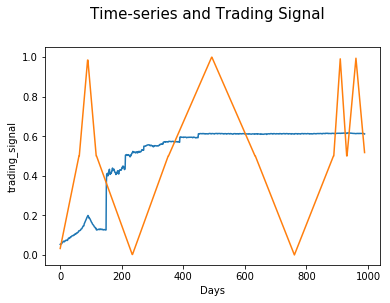

In [449]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred)
plt.plot(y_test_sep)
plt.title('')
plt.ylabel('trading_signal')
plt.xlabel('Days')
plt.suptitle("Time-series and Trading Signal", y = 1.02, size = 15)
#plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)


